# Assignment 1 Big Data Visualization
## By Vyanna Hill

In [1]:
#Importing libraries used
import pandas as pd
import numpy as np
import plotly.express as px
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

#From Homework module, setting up export
export = partial(export_image, background = "black", export_path="export")


#Importing data from our csv
data=pd.read_csv("pluto_22v3.csv")

#taking this line from the template for some data cleanup
data = data[(data['yearbuilt'] > 1850) & (data['yearbuilt'] < 2022) & (data['numfloors'] != 0)]
data.head()

C:\Users\walki\AppData\Local\Temp\ipykernel_19788\260344344.py:17: DtypeWarning: Columns (21,22,24,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("pluto_22v3.csv")


,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
1,BK,3435,45,304.0,3041100.0,3.041100e+10,411.0,1000.0,32.0,37.0,...,NaN,NaN,1,NaN,NaN,22v3,NaN,40.688820,-73.906684,NaN
2,BK,3447,29,304.0,3041100.0,3.041100e+10,411.0,1002.0,32.0,37.0,...,NaN,NaN,1,NaN,NaN,22v3,NaN,40.688377,-73.905239,NaN
3,BX,2514,10,204.0,2019300.0,2.019300e+10,193.0,4001.0,9.0,8.0,...,NaN,NaN,1,NaN,NaN,22v3,NaN,40.834979,-73.927858,NaN
4,MN,482,7501,102.0,1004500.0,1.004500e+10,45.0,1006.0,2.0,1.0,...,1.004821e+09,08/25/1988,1,NaN,NaN,22v3,NaN,40.721202,-73.997742,NaN
5,BK,3434,8,304.0,3041100.0,3.041100e+10,411.0,2000.0,32.0,37.0,...,NaN,NaN,1,NaN,NaN,22v3,NaN,40.687098,-73.908828,NaN


### Part 1 Binning and Aggregation
We are finding the amount of building built with a specific range of floors the year of its creation. It appears we are creating groups of stories where the range of the bins are nine. Below, we can group by catoegrizing the buidling's story with pd.cut(). The data is bin with the range of nine stories for each size, so all of the stories are not left out. For the part in the question of buildings of larger sizes, for now we can adjust our max range with finding out the largest building in our set and reset the bin range. The year built information is accurate at the decade level for all values but for values between 1800s-1910s there's a discrepancy for the exact year. We can bin the year data to be at the decade level, which will help with the overall size of the barplot and see the data as accurate as possible. 


One issue was the plot, as using the plotly with all renders for a barplot broken my console in all attempts. This can mean plotly needs a heavier memory to complete this task but matplotlib/seaborn can handle the large data. For the hopes to show off the range and the frequency between story bins. Following the advice in the module, I scaled down the x-axis to the log of 10 to see the data more closely.

In [2]:
#Lets see the stats of numfloor , 104 is the largest story recorded
data["numfloors"].describe()

#Knowing the max storires,we can set ou range to end at 104 when creating our bins
data["bins"]=pd.cut(data["numfloors"],np.arange(0,114,10),include_lowest=True,labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99","100-109"])
data["decades"]=pd.cut(data["yearbuilt"],np.arange(1850,2032,10),include_lowest=True,labels=["1850", "1860", "1870", "1880", "1890", "1900", "1910", "1920", "1930", "1940", "1950","1960", "1970", "1980", "1990","2000", "2010", "2020"])

In [3]:
#plotly attempt, it broke my console :( 
#fig=px.bar(data,x="yearbuilt",y="bins",color="bins",text_auto=True,barmode="stack")
#fig.show()

[Text(0.5, 1.0, 'Building Counts By Year'),
 Text(0.5, 0, 'Building count'),
 Text(0, 0.5, 'Year of Building Built')]

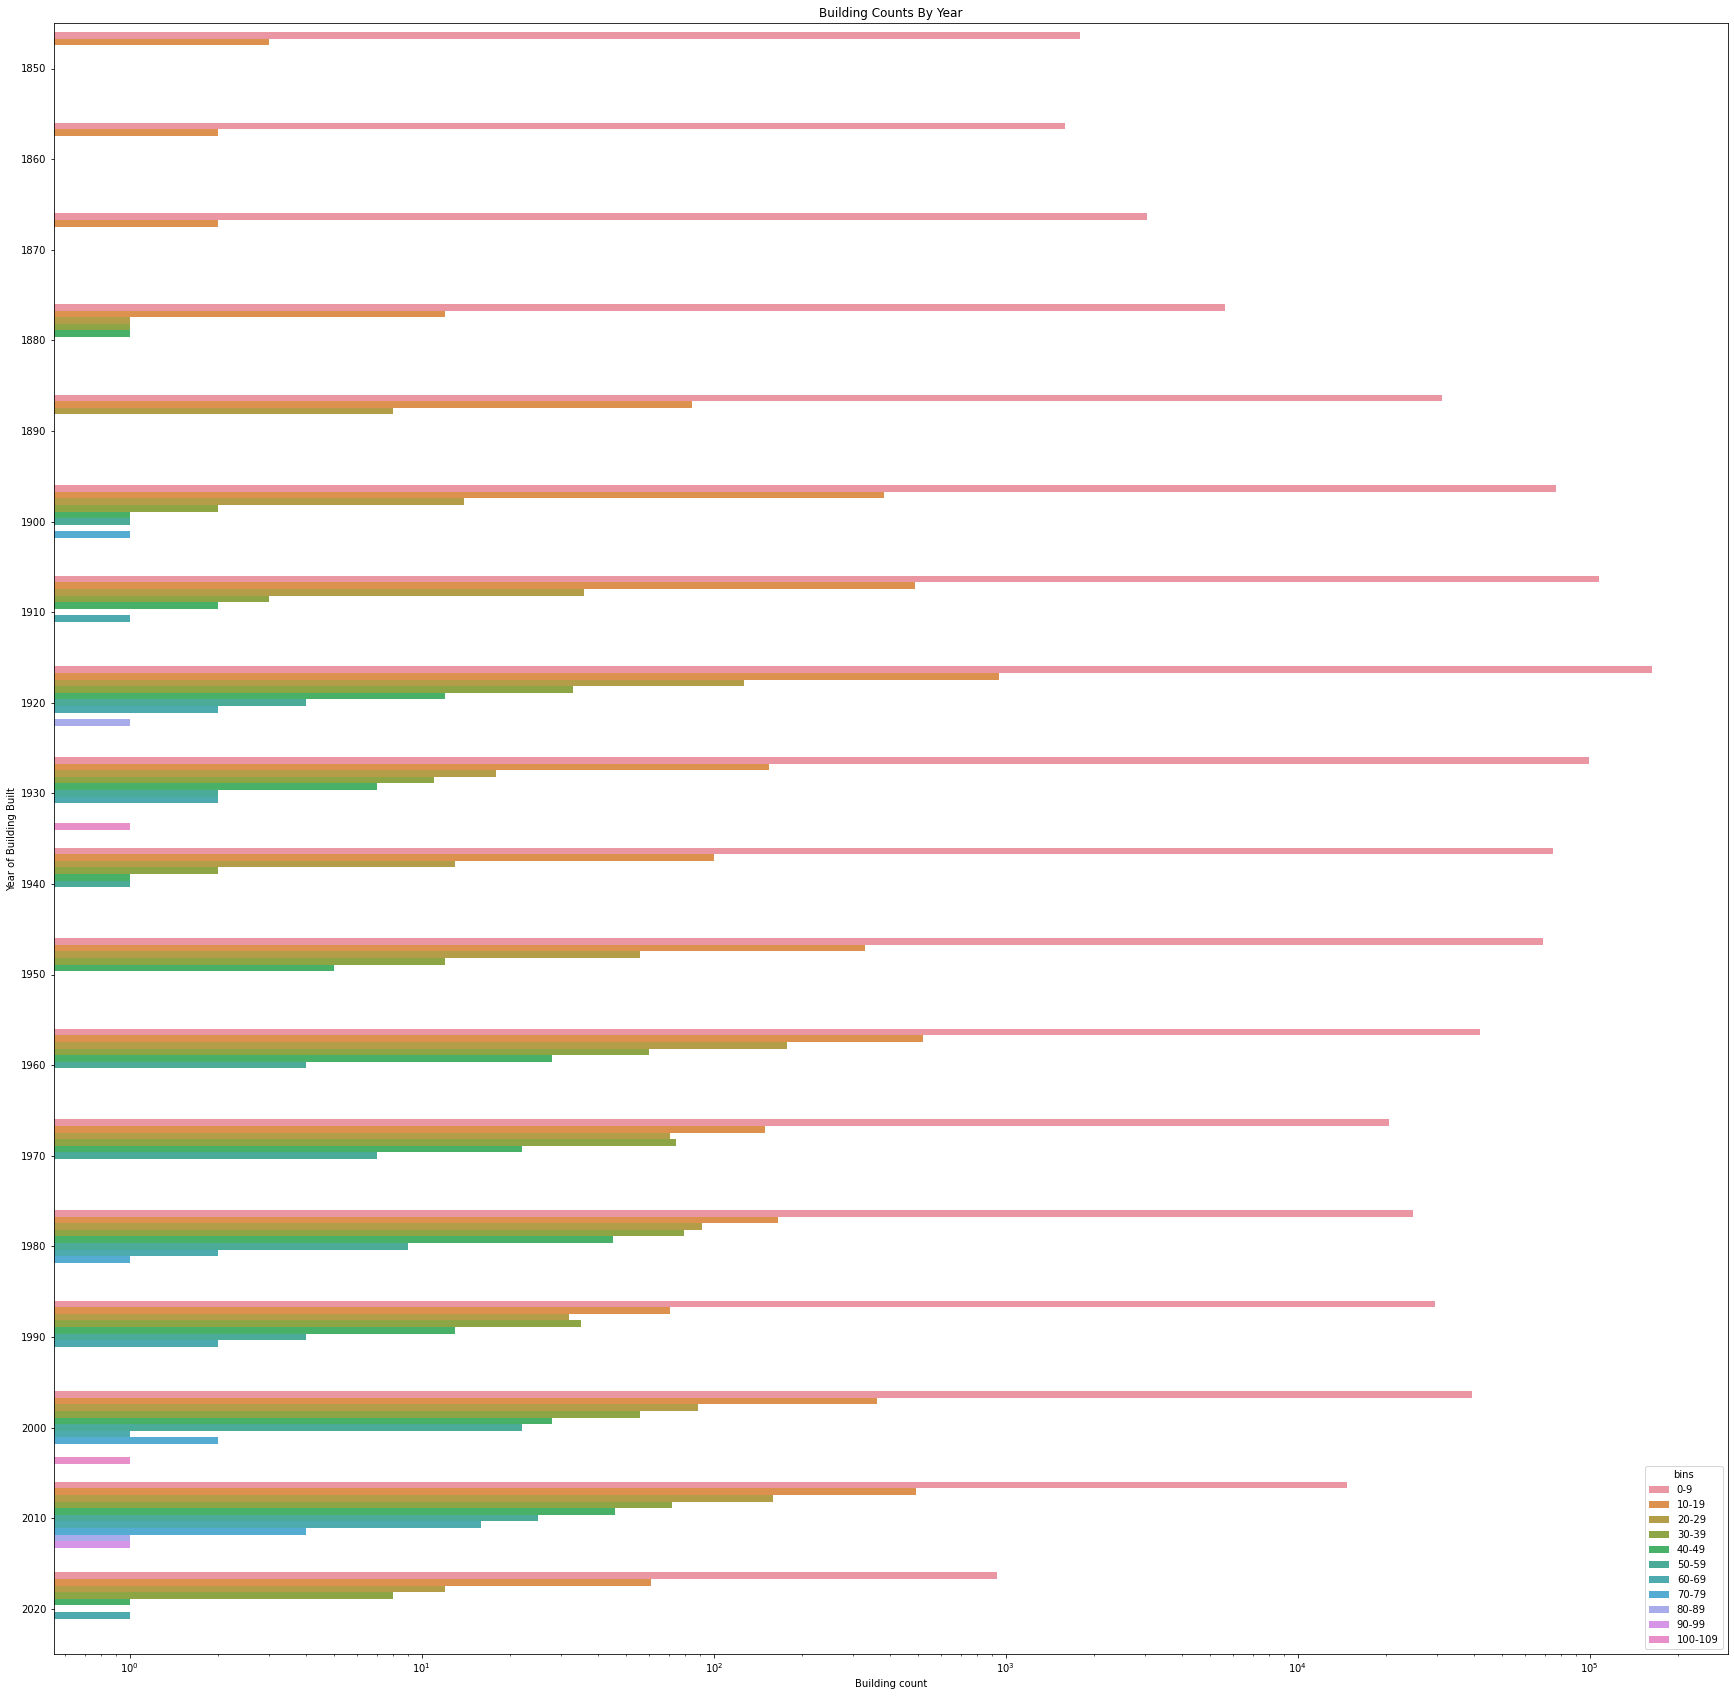

In [4]:
#Plot how many of the bin was created. We can use countplot to see th frequency of these buidlings by 
#A lot of 20-29 stories built between 1920s and the 1960s. One buidling the 1930s was the first of above 100 stories (It's the empire state buidling )
plt.figure(figsize=(30,30))
plt.xscale('log',base=10) 
sns.countplot(data=data, y="decades", hue="bins").set(title='Building Counts By Year',xlabel="Building count",ylabel="Year of Building Built")

### Part 2 Datashader

For this question, I will follow along the JS article supply in the homework to create the bivariate choropleth map. First, we have to create  a color scheme for the two variables sorting through their low to high. So, we have to corridnate or scale of "three classes" between the two variables. In the JS article, the hortinozal variable  will receive the labels of "A,B,C" and the verticle will be "1,2,3". We have to translate the Land assement values on the A-C scale and the structure assement on the 1-3 scale. We can create the mapping by creating new columns to rank the Land/Building assement and its combined score. The best score following the scale will be C3, as it's the best land assement and the best structural assement.

The percentiles for the breakpoints are found using np.percentile() as we need to return the two [breakpoints](https://datagy.io/numpy-percentile/). Looking at our land percentiles, it return the land values at the 33th breakpoint ($ 33,300) and the 66th percentile ($59,940). When looking to asses scores,these prices ranges will categoize the buldings score. For example, ($ 0,$33,300)-first breakpoint ($ 33,300-$59,940)- second breakpoint ($ 59,940-highest value possible) needs  to make up the bin ranges for our percentiles. This logic will also follow for the building asessment score. 

Afterwards, we can move forward to grading the buildings by their Land/Structual assements and assigned their attributes. Finding the bi class attributed, we move forward to the last step and created our choropleth map. To bind the bi class atribute, we need to use the ds.count agggreator to specificy that we want to use our own color map to match each point to its bi class [category](https://stackoverflow.com/questions/68358278/datashader-categorical-colormapping-of-geodataframes).

Looking at our graph, it appears boroughs like staten island and east queens have lower value in terms of land/structual assesment compared to manthattan and upper brooklyn. It can be inferred that the weatlth is more concentrated in the island is more built compared the lighter parts of the map. The areas will the lower catogorical score may be more availabe to new developments which can raise its value in the future.

In [5]:
#To not loose my mind, lets assume total-land=bulding assement value
data["assesbuilding"]= data["assesstot"]-data["assessland"]

#we can find a breakpts for the 33th and 66th breakpt for classes for both variable via np.percentile()
#we are returning the tuple of the  breakpts with the percentile of the row values
land_per=np.percentile(data["assessland"],[(100/3),100-(100/3)],axis=0)
bd_per=np.percentile(data["assesbuilding"],[(100/3),100-(100/3)],axis=0)

#Binning our land/building assements into the grades, I noticed in the JS article its inclusive (greater than or equal) so I turn off the rigth most edge defualt
#As this cateogizes the cost, the largest value for both in describe was in log form so i set the value to infinity just incase
# We can use pandas str concat function to combine the two variables together for the overall score
data["var1_class"]=pd.cut(data["assessland"],[0,land_per[0],land_per[1],np.inf],labels=["A","B","C"],right=False)
data["var2_class"]=pd.cut(data["assesbuilding"],[0,bd_per[0],bd_per[1],np.inf],labels=["1","2","3"],right=False)
data["bi_class"]=data["var1_class"].str.cat(data["var2_class"], sep="")
data["bi_class"]=pd.Categorical(data["bi_class"])

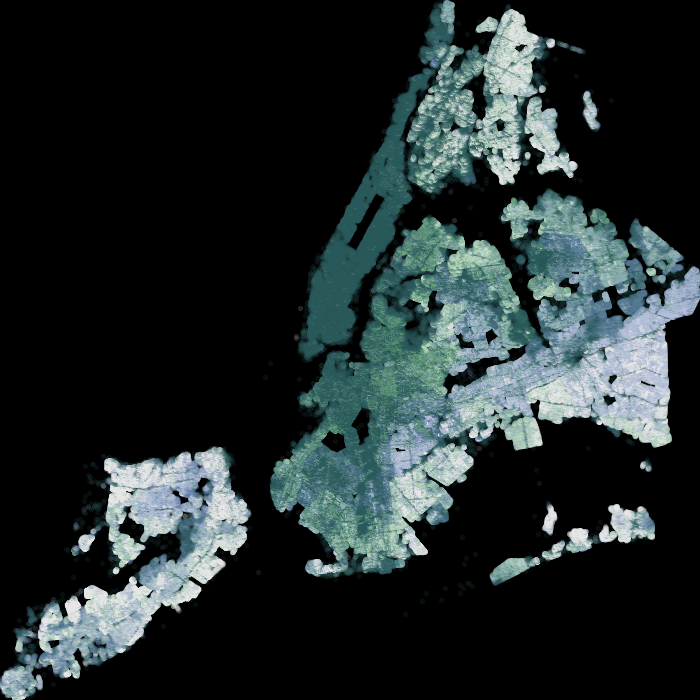

In [6]:
#creating a color scheme for our bi classes. Let's use the third color scheme given in the article
color={"A1":"#e8e8e8","A2":"#b8d6be","A3":"#73ae80","B1":"#b5c0da","B2":"#90b2b3","B3":"#5a9178","C1":"#6c83b5","C2":"#567994","C3":"#2a5a5b"}

#Borrowing the two following two lines from the Homework
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)

#for our points, we can now plot the locations of the buildings 
#To specific a our color scheme we have to use ds.count to speciify a color scheme by a category
agg = cvs.points(data, 'xcoord', 'ycoord',ds.count_cat("bi_class"))
view = tf.shade(agg, color_key=color)
export(tf.spread(view, px=2), 'cloropleth')
